<a href="https://www.kaggle.com/code/gopikavs/comparison-of-classifiers?scriptVersionId=142395577" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Nai code
```
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd

import random
import math
import re
import string
import nltk

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# class NotADirectoryError(Exception):
#     pass

spam = "/kaggle/input/spamanti-spam/spam.csv"
ham = "/kaggle/input/spamanti-spam/ham.csv"

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', '', text)
    words = text.split()
    stopwords = ["a", "an", "the", "and", "or", "not", "in", "on", "at", "to", "from", "by", "with", "for", "of", "that", "this", "is"]
    words = [word for word in words if word not in stopwords]
    porter = nltk.PorterStemmer()
    words = [porter.stem(word) for word in words]
    text = " ".join(words)
    return text

def load_messages(directory):
    messages = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), "r") as f:
            text = f.read()
            text = preprocess_text(text)
            messages.append((text, directory))
    return messages

class NotADirectoryError(Exception):
    pass

spam_messages = load_messages(spam)
ham_messages = load_messages(ham)
messages = spam_messages + ham_messages
random.shuffle(messages)

split = math.floor(len(messages) * 0.8)
train_set = messages[:split]
test_set = messages[split:]
```

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download("punkt")
from nltk.tokenize import word_tokenize
import re

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Conv2D,Dense,Flatten,Input
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,fbeta_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron,LogisticRegression
import xgboost as xgb

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv('/kaggle/input/ham-spam-classification/newspam_ham_dataset.csv')
df.head()

,text,label_num
0,enron methanol ; meter # : 988291\r\nthis is a...,0
1,"hpl nom for january 9 , 2001\r\n( see attached...",0
2,"neon retreat\r\nho ho ho , we ' re around to t...",0
3,"photoshop , windows , office . cheap . main tr...",1
4,re : indian springs\r\nthis deal is to book th...,0


In [3]:
text = []
unique_words = []
stop_words = set(stopwords.words('english')) 
for i in df['text']:
    text_tokens = word_tokenize(i)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    filtered_sentence = " ".join(tokens_without_sw)
    filtered_sentence = re.findall(r'[A-Za-z0-9]+',filtered_sentence)
    filtered_sentence_r = filtered_sentence
    for i in filtered_sentence:
        if i not in unique_words:
            unique_words.append(i)
#         if len(i) == 1:
#             filtered_sentence.remove(i)
    filtered_sentence = " ".join(filtered_sentence)
    text.append(filtered_sentence)

In [4]:
len(text)

10735

In [5]:
text[:3]

['enron methanol meter 988291 follow note gave monday 4 3 00 preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purposes',
 'hpl nom january 9 2001 see attached file hplnol 09 xls hplnol 09 xls',
 'neon retreat ho ho ho around wonderful time year neon leaders retreat time know time year extremely hectic tough think anything past holidays life go past week december 25 january 1 like think minute calender handed beginning fall semester retreat scheduled weekend january 5 6 youth ministers conference brad dustin connected week going change date following weekend january 12 13 comes part need think think agree important us get together time recharge batteries get far spring semester lot trouble difficult us get away without kids etc brad came potential alternative get together weekend let know prefer first option would retreat similar done past several years year could go heartland coun

In [6]:
df = pd.DataFrame({'Sentence':text,'Labels':df['label_num']})
df.head()

,Sentence,Labels
0,enron methanol meter 988291 follow note gave m...,0
1,hpl nom january 9 2001 see attached file hplno...,0
2,neon retreat ho ho ho around wonderful time ye...,0
3,photoshop windows office cheap main trending a...,1
4,indian springs deal book teco pvr revenue unde...,0


In [7]:
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(df['Sentence']).toarray()
y = df.Labels.values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

In [9]:
gauss = GaussianNB()
gauss.fit(X_train,y_train)
gauss_pred = gauss.predict(X_test)
gauss_accuracy_score = round(accuracy_score(y_test,gauss_pred)*100,2)
gauss_precision_score = round(precision_score(y_test,gauss_pred)*100,2)
gauss_recall_score = round(recall_score(y_test,gauss_pred)*100,2)
gauss_f1_score = round(f1_score(y_test,gauss_pred)*100,2)
gauss_fbeta_score = round(fbeta_score(y_test,gauss_pred, beta=0.5)*100,2)
gauss_confusion_matrix = confusion_matrix(y_test,gauss_pred)
print(gauss_accuracy_score," ",gauss_precision_score," ",gauss_recall_score," ",gauss_f1_score," ",gauss_fbeta_score,'\n',gauss_confusion_matrix)

61.43   34.7   96.21   51.01   39.79 
 [[888 811]
 [ 17 431]]


In [10]:
svm = SVC()
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)
svm_accuracy_score = round(accuracy_score(y_test,svm_pred)*100,2)
svm_precision_score = round(precision_score(y_test,svm_pred)*100,2)
svm_recall_score = round(recall_score(y_test,svm_pred)*100,2)
svm_f1_score = round(f1_score(y_test,svm_pred)*100,2)
svm_fbeta_score = round(fbeta_score(y_test,svm_pred, beta=0.5)*100,2)
svm_confusion_matrix = confusion_matrix(y_test,svm_pred)
print(svm_accuracy_score," ",svm_precision_score," ",svm_recall_score," ",svm_f1_score," ",svm_fbeta_score,'\n',svm_confusion_matrix)

91.24   96.76   60.04   74.1   86.22 
 [[1690    9]
 [ 179  269]]


In [11]:
multi = MultinomialNB()
multi.fit(X_train,y_train)
multi_pred = multi.predict(X_test)
multi_accuracy_score = round(accuracy_score(y_test,multi_pred)*100,2)
multi_precision_score = round(precision_score(y_test,multi_pred)*100,2)
multi_recall_score = round(recall_score(y_test,multi_pred)*100,2)
multi_f1_score = round(f1_score(y_test,multi_pred)*100,2)
multi_fbeta_score = round(fbeta_score(y_test,multi_pred, beta=0.5)*100,2)
multi_confusion_matrix = confusion_matrix(y_test,multi_pred)
print(multi_accuracy_score," ",multi_precision_score," ",multi_recall_score," ",multi_f1_score," ",multi_fbeta_score,'\n',multi_confusion_matrix)

89.61   68.78   91.96   78.7   72.43 
 [[1512  187]
 [  36  412]]


In [12]:
grd = GradientBoostingClassifier()
grd.fit(X_train,y_train)
grd_pred = grd.predict(X_test)
grd_accuracy_score = round(accuracy_score(y_test,grd_pred)*100,2)
grd_precision_score = round(precision_score(y_test,grd_pred)*100,2)
grd_recall_score = round(recall_score(y_test,grd_pred)*100,2)
grd_f1_score = round(f1_score(y_test,grd_pred)*100,2)
grd_fbeta_score = round(fbeta_score(y_test,grd_pred, beta=0.5)*100,2)
grd_confusion_matrix = confusion_matrix(y_test,grd_pred)
print(grd_accuracy_score," ",grd_precision_score," ",grd_recall_score," ",grd_f1_score," ",grd_fbeta_score,'\n',grd_confusion_matrix)

90.92   93.47   60.71   73.61   84.37 
 [[1680   19]
 [ 176  272]]


In [13]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
ada_pred = ada.predict(X_test)
ada_accuracy_score = round(accuracy_score(y_test,ada_pred)*100,2)
ada_precision_score = round(precision_score(y_test,ada_pred)*100,2)
ada_recall_score = round(recall_score(y_test,ada_pred)*100,2)
ada_f1_score = round(f1_score(y_test,ada_pred)*100,2)
ada_fbeta_score = round(fbeta_score(y_test,ada_pred, beta=0.5)*100,2)
ada_confusion_matrix = confusion_matrix(y_test,ada_pred)
print(ada_accuracy_score," ",ada_precision_score," ",ada_recall_score," ",ada_f1_score," ",ada_fbeta_score,'\n',ada_confusion_matrix)

91.52   89.58   67.19   76.79   83.98 
 [[1664   35]
 [ 147  301]]


In [14]:
rnd = RandomForestClassifier()
rnd.fit(X_train,y_train)
rnd_pred = rnd.predict(X_test)
rnd_accuracy_score = round(accuracy_score(y_test,rnd_pred)*100,2)
rnd_precision_score = round(precision_score(y_test,rnd_pred)*100,2)
rnd_recall_score = round(recall_score(y_test,rnd_pred)*100,2)
rnd_f1_score = round(f1_score(y_test,rnd_pred)*100,2)
rnd_fbeta_score = round(fbeta_score(y_test,rnd_pred, beta=0.5)*100,2)
rnd_confusion_matrix = confusion_matrix(y_test,rnd_pred)
print(rnd_accuracy_score," ",rnd_precision_score," ",rnd_recall_score," ",rnd_f1_score," ",rnd_fbeta_score,'\n',rnd_confusion_matrix)

95.67   92.98   85.71   89.2   91.43 
 [[1670   29]
 [  64  384]]


In [15]:
xg = xgb.XGBClassifier()
xg.fit(X_train,y_train)
xg_pred = xg.predict(X_test)
xg_accuracy_score = round(accuracy_score(y_test,xg_pred)*100,2)
xg_precision_score = round(precision_score(y_test,xg_pred)*100,2)
xg_recall_score = round(recall_score(y_test,xg_pred)*100,2)
xg_f1_score = round(f1_score(y_test,xg_pred)*100,2)
xg_fbeta_score = round(fbeta_score(y_test,xg_pred, beta=0.5)*100,2)
xg_confusion_matrix = confusion_matrix(y_test,xg_pred)
print(xg_accuracy_score," ",xg_precision_score," ",xg_recall_score," ",xg_f1_score," ",xg_fbeta_score,'\n',xg_confusion_matrix)

95.48   95.35   82.37   88.38   92.43 
 [[1681   18]
 [  79  369]]


In [16]:
dec = DecisionTreeClassifier()
dec.fit(X_train,y_train)
dec_pred = dec.predict(X_test)
dec_accuracy_score = round(accuracy_score(y_test,dec_pred)*100,2)
dec_precision_score = round(precision_score(y_test,dec_pred)*100,2)
dec_recall_score = round(recall_score(y_test,dec_pred)*100,2)
dec_f1_score = round(f1_score(y_test,dec_pred)*100,2)
dec_fbeta_score = round(fbeta_score(y_test,dec_pred, beta=0.5)*100,2)
dec_confusion_matrix = confusion_matrix(y_test,dec_pred)
print(dec_accuracy_score," ",dec_precision_score," ",dec_recall_score," ",dec_f1_score," ",dec_fbeta_score,'\n',dec_confusion_matrix)

91.62   79.91   79.91   79.91   79.91 
 [[1609   90]
 [  90  358]]


In [17]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
knn_accuracy_score = round(accuracy_score(y_test,knn_pred)*100,2)
knn_precision_score = round(precision_score(y_test,knn_pred)*100,2)
knn_recall_score = round(recall_score(y_test,knn_pred)*100,2)
knn_f1_score = round(f1_score(y_test,knn_pred)*100,2)
knn_fbeta_score = round(fbeta_score(y_test,knn_pred, beta=0.5)*100,2)
knn_confusion_matrix = confusion_matrix(y_test,knn_pred)
print(knn_accuracy_score," ",knn_precision_score," ",knn_recall_score," ",knn_f1_score," ",knn_fbeta_score,'\n',knn_confusion_matrix)

87.84   88.8   47.77   62.12   75.78 
 [[1672   27]
 [ 234  214]]


In [18]:
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)
mlp_accuracy_score = round(accuracy_score(y_test,mlp_pred)*100,2)
mlp_precision_score = round(precision_score(y_test,mlp_pred)*100,2)
mlp_recall_score = round(recall_score(y_test,mlp_pred)*100,2)
mlp_f1_score = round(f1_score(y_test,mlp_pred)*100,2)
mlp_fbeta_score = round(fbeta_score(y_test,mlp_pred, beta=0.5)*100,2)
mlp_confusion_matrix = confusion_matrix(y_test,mlp_pred)
print(mlp_accuracy_score," ",mlp_precision_score," ",mlp_recall_score," ",mlp_f1_score," ",mlp_fbeta_score,'\n',mlp_confusion_matrix)

94.83   90.21   84.38   87.2   88.98 
 [[1658   41]
 [  70  378]]


In [19]:
per = Perceptron()
per.fit(X_train,y_train)
per_pred = per.predict(X_test)
per_accuracy_score = round(accuracy_score(y_test,per_pred)*100,2)
per_precision_score = round(precision_score(y_test,per_pred)*100,2)
per_recall_score = round(recall_score(y_test,per_pred)*100,2)
per_f1_score = round(f1_score(y_test,per_pred)*100,2)
per_fbeta_score = round(fbeta_score(y_test,per_pred, beta=0.5)*100,2)
per_confusion_matrix = confusion_matrix(y_test,per_pred)
print(per_accuracy_score," ",per_precision_score," ",per_recall_score," ",per_f1_score," ",per_fbeta_score,'\n',per_confusion_matrix)

93.99   88.07   82.37   85.12   86.86 
 [[1649   50]
 [  79  369]]


In [20]:
log = LogisticRegression()
log.fit(X_train,y_train)
log_pred = log.predict(X_test)
log_accuracy_score = round(accuracy_score(y_test,log_pred)*100,2)
log_precision_score = round(precision_score(y_test,log_pred)*100,2)
log_recall_score = round(recall_score(y_test,log_pred)*100,2)
log_f1_score = round(f1_score(y_test,log_pred)*100,2)
log_fbeta_score = round(fbeta_score(y_test,log_pred, beta=0.5)*100,2)
log_confusion_matrix = confusion_matrix(y_test,log_pred)
print(log_accuracy_score," ",log_precision_score," ",log_recall_score," ",log_f1_score," ",log_fbeta_score,'\n',log_confusion_matrix)

95.39   95.56   81.7   88.09   92.42 
 [[1682   17]
 [  82  366]]


In [21]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(64,activation='tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
# model.summary()

In [22]:
model.fit(X_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
269/269 [==============================] - 1s 2ms/step - loss: 0.6332 - accuracy: 0.6906
Epoch 2/30
269/269 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.8578
Epoch 3/30
269/269 [==============================] - 1s 2ms/step - loss: 0.4314 - accuracy: 0.8826
Epoch 4/30
269/269 [==============================] - 1s 2ms/step - loss: 0.3735 - accuracy: 0.9015
Epoch 5/30
269/269 [==============================] - 1s 2ms/step - loss: 0.3262 - accuracy: 0.9156
Epoch 6/30
269/269 [==============================] - 1s 2ms/step - loss: 0.2862 - accuracy: 0.9270
Epoch 7/30
269/269 [==============================] - 1s 2ms/step - loss: 0.2577 - accuracy: 0.9334
Epoch 8/30
269/269 [==============================] - 1s 2ms/step - loss: 0.2313 - accuracy: 0.9386
Epoch 9/30
269/269 [==============================] - 1s 2ms/step - loss: 0.2089 - accuracy: 0.9446
Epoch 10/30
269/269 [==============================] - 1s 2ms/step - loss: 0.1915 - accuracy: 0.9459

In [23]:
loss, acc = model.evaluate(X_test, y_test,verbose=0)
nn_accuracy_score = round(acc*100,2)

yhat_probs = model.predict(X_test, verbose=0)
predict_x=model.predict(X_test, verbose=0) 
yhat_classes=np.round(predict_x)
yhat_probs = yhat_probs[:, 0]
nn_accuracy_score = round(accuracy_score(y_test, yhat_classes)*100,2)
nn_precision_score = round(precision_score(y_test, yhat_classes)*100,2)
nn_recall_score = round(recall_score(y_test, yhat_classes)*100,2)
nn_f1_score = round(f1_score(y_test, yhat_classes)*100,2)
nn_fbeta_score = round(fbeta_score(y_test, yhat_classes, beta=0.5)*100,2)
print(nn_accuracy_score,nn_precision_score,nn_recall_score,nn_f1_score,nn_fbeta_score)

95.76 95.65 83.48 89.15 92.94


In [24]:
acc_df = pd.DataFrame(
{
    'Models':['GaussianNB','MultinomialNB','SVC','GradientBoostingClassifier','AdaBoostClassifier','RandomForestClassifier','DecisionTreeClassifier','KNeighborsClassifier','MLPClassifier','Perceptron','LogisticRegression','xgb','NN'],
    'Accuracy':[gauss_accuracy_score,multi_accuracy_score,svm_accuracy_score,grd_accuracy_score,ada_accuracy_score,rnd_accuracy_score,dec_accuracy_score,knn_accuracy_score,mlp_accuracy_score,per_accuracy_score,log_accuracy_score,xg_accuracy_score,nn_accuracy_score],
    'Precision':[gauss_precision_score,multi_precision_score,svm_precision_score,grd_precision_score,ada_precision_score,rnd_precision_score,dec_precision_score,knn_precision_score,mlp_precision_score,per_precision_score,log_precision_score,xg_precision_score,nn_precision_score],
    'Recall':[gauss_recall_score,multi_recall_score,svm_recall_score,grd_recall_score,ada_recall_score,rnd_recall_score,dec_recall_score,knn_recall_score,mlp_recall_score,per_recall_score,log_recall_score,xg_recall_score,nn_recall_score],
    'F1':[gauss_f1_score,multi_f1_score,svm_f1_score,grd_f1_score,ada_f1_score,rnd_f1_score,dec_f1_score,knn_f1_score,mlp_f1_score,per_f1_score,log_f1_score,xg_f1_score,nn_f1_score],
    'Fbeta':[gauss_fbeta_score,multi_fbeta_score,svm_fbeta_score,grd_fbeta_score,ada_fbeta_score,rnd_fbeta_score,dec_fbeta_score,knn_fbeta_score,mlp_fbeta_score,per_fbeta_score,log_fbeta_score,xg_fbeta_score,nn_fbeta_score]
}
)
acc_df

,Models,Accuracy,Precision,Recall,F1,Fbeta
0,GaussianNB,61.43,34.70,96.21,51.01,39.79
1,MultinomialNB,89.61,68.78,91.96,78.70,72.43
2,SVC,91.24,96.76,60.04,74.10,86.22
3,GradientBoostingClassifier,90.92,93.47,60.71,73.61,84.37
4,AdaBoostClassifier,91.52,89.58,67.19,76.79,83.98
5,RandomForestClassifier,95.67,92.98,85.71,89.20,91.43
6,DecisionTreeClassifier,91.62,79.91,79.91,79.91,79.91
7,KNeighborsClassifier,87.84,88.80,47.77,62.12,75.78
8,MLPClassifier,94.83,90.21,84.38,87.20,88.98
9,Perceptron,93.99,88.07,82.37,85.12,86.86


<Axes: xlabel='Models', ylabel='Accuracy'>

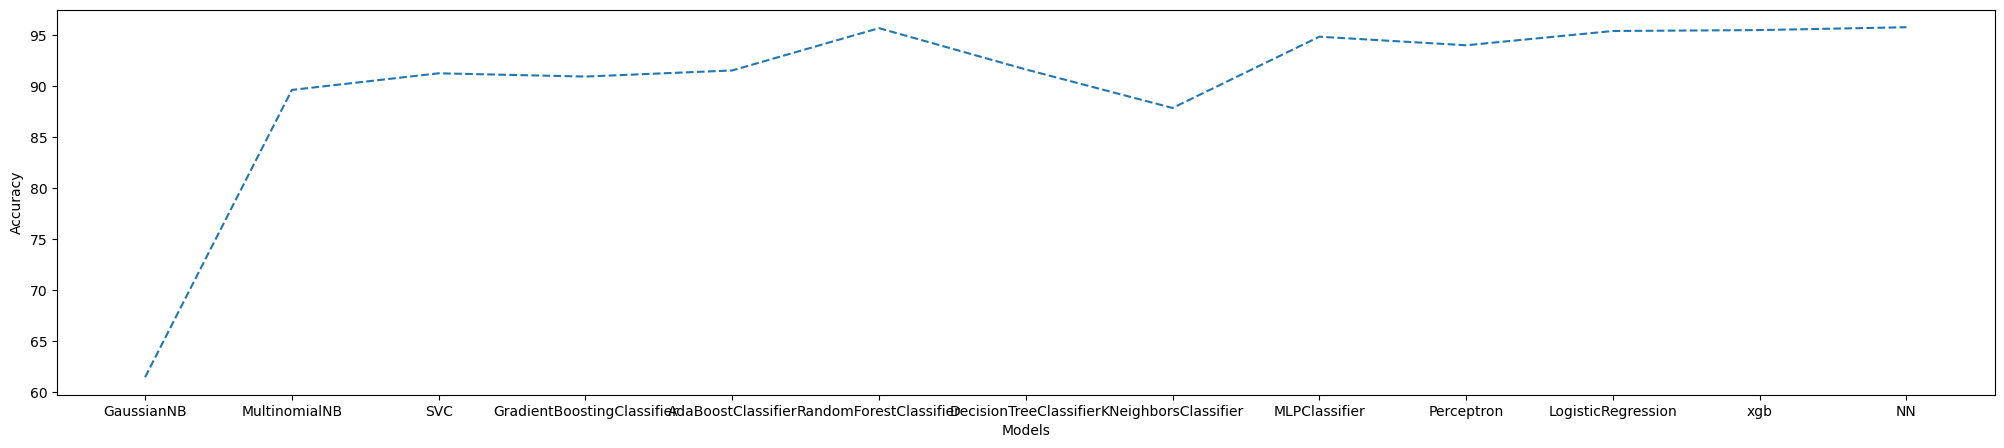

In [25]:
plt.figure(figsize=(25,5))
sns.lineplot(x='Models',y='Accuracy',data=acc_df,linestyle='--',markers="o")